<a href="https://colab.research.google.com/github/JungWoo-Chae/GANs-in-action/blob/master/chapter-4/4_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chapter 4: Deep Convolutional GAN (DCGAN)**


# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyperparameters


In [3]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)

z_dim = 100

# Define the Model

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        
        self.fc = nn.Linear(z_dim, 256*7*7)
        self.g_deconv_1 = nn.Sequential(
                          nn.ConvTranspose2d(256, 128, kernel_size=3,
                                    stride= 2, padding=(3-2+1)//2,
                                    output_padding = (3-2)%2), 
                          nn.BatchNorm2d(128),
                          nn.LeakyReLU()
                          )
        self.g_deconv_2 = nn.Sequential(
                          nn.ConvTranspose2d(128, 64, kernel_size=3,
                                    stride= 1, padding=(3-1+1)//2,
                                    output_padding = (3-1)%2), 
                          nn.BatchNorm2d(64),
                          nn.LeakyReLU()
                          )
        self.g_deconv_3 = nn.Sequential(
                          nn.ConvTranspose2d(64, 1, kernel_size=3,
                                    stride= 2, padding=(3-2+1)//2,
                                    output_padding = (3-2)%2),
                          nn.Tanh()
                          )
        
        

    def forward(self, x):
        x = self.fc(x).view(-1, 256, 7, 7)
        x = self.g_deconv_1(x)
        x = self.g_deconv_2(x)
        x = self.g_deconv_3(x)
        
        return x

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.d_conv_1 = nn.Sequential(
                          nn.Conv2d(1, 32, kernel_size=3,
                                    stride=2, padding=1), 
                          nn.LeakyReLU()
                          )
        self.d_conv_2 = nn.Sequential(
                          nn.Conv2d(32, 64, kernel_size=3,
                                    stride=2, padding=1), 
                          nn.LeakyReLU()
                          )
        self.d_conv_3 = nn.Sequential(
                          nn.Conv2d(64, 128, kernel_size=3,
                                    stride=2, padding=0), 
                          nn.LeakyReLU()
                          )
        self.fc = nn.Linear(3*3*128, 1)

    def forward(self, x):
        x = self.d_conv_1(x)
        x = self.d_conv_2(x)
        x = self.d_conv_3(x)
        x = x.view(-1, 128*3*3)
        x = torch.sigmoid(self.fc(x))
        return x

In [6]:
discriminator = Discriminator()
discriminator = discriminator.to(device)
generator = Generator(z_dim)
generator = generator.to(device)

In [7]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: 2*x-1)
    ])

In [8]:
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Training

In [9]:
losses = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    
    discriminator.train()
    generator.train()

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                           shuffle=True, num_workers=4, pin_memory=True)
    
    dataiter = iter(train_loader)
    

    real = torch.ones( batch_size, 1, device=device, dtype=torch.float)
    fake = torch.zeros( batch_size, 1, device=device, dtype=torch.float)

    criterion = nn.BCELoss()
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001)
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001)

    for iteration in range(iterations):
        imgs, _ = dataiter.next()
        imgs = imgs.to(device)

        if len(imgs) != batch_size:
            dataiter = iter(train_loader)
            imgs, _ = dataiter.next()
            imgs = imgs.to(device)
        
        z = torch.randn(batch_size, z_dim, device=device)
        gen_imgs = generator(z)

        outputs_real = discriminator(imgs)
        outputs_fake = discriminator(gen_imgs)

        d_loss_real = criterion(outputs_real, real)
        d_loss_fake = criterion(outputs_fake, fake)

        d_loss = d_loss_real + d_loss_fake

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()


        z = torch.randn(batch_size, z_dim, device=device)
        gen_imgs = generator(z)
        g_loss = criterion(discriminator(gen_imgs), real)
        
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()



        if (iteration + 1) % sample_interval == 0:
            losses.append((d_loss.cpu().detach().numpy(), g_loss.cpu().detach().numpy()))
            iteration_checkpoints.append(iteration + 1)

            print("%d [D loss: %f] [G loss: %f]" % (iteration + 1, d_loss, g_loss))

            sample_images(generator)
        


In [10]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    z = torch.randn(image_grid_rows * image_grid_columns, z_dim, device=device)

    gen_imgs = generator(z).cpu().detach()

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):

            axs[i, j].imshow(gen_imgs[cnt].view(28,28), cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

## Train the Model and Inspect Output

1000 [D loss: 0.714392] [G loss: 1.783756]
2000 [D loss: 0.951946] [G loss: 1.477292]
3000 [D loss: 1.018412] [G loss: 1.326545]
4000 [D loss: 0.867736] [G loss: 1.552382]
5000 [D loss: 0.806832] [G loss: 2.263701]
6000 [D loss: 0.732260] [G loss: 2.046077]
7000 [D loss: 0.653061] [G loss: 2.223646]
8000 [D loss: 0.695918] [G loss: 2.414838]
9000 [D loss: 0.819808] [G loss: 1.753548]
10000 [D loss: 0.675867] [G loss: 2.032929]
11000 [D loss: 0.674559] [G loss: 2.452350]
12000 [D loss: 0.760067] [G loss: 2.107580]
13000 [D loss: 0.720346] [G loss: 2.653600]
14000 [D loss: 0.557988] [G loss: 2.536022]
15000 [D loss: 0.610663] [G loss: 2.427280]
16000 [D loss: 0.644452] [G loss: 2.558352]
17000 [D loss: 0.513994] [G loss: 2.728369]
18000 [D loss: 0.591996] [G loss: 2.299141]
19000 [D loss: 0.648018] [G loss: 2.808783]
20000 [D loss: 0.664494] [G loss: 2.411436]


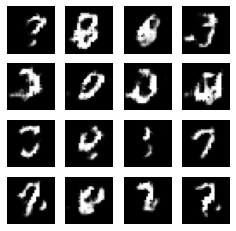

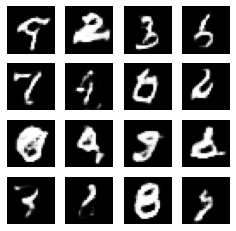

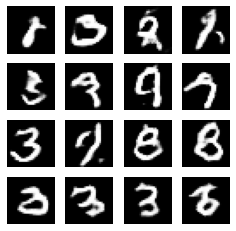

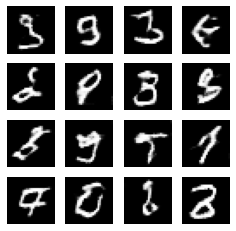

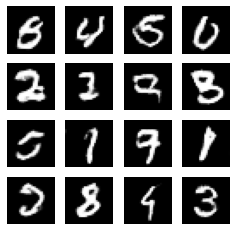

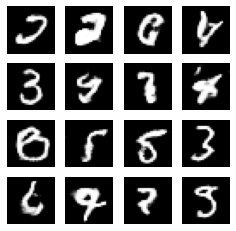

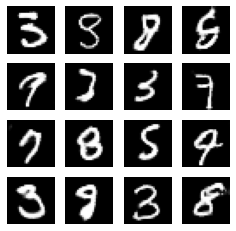

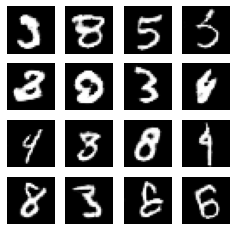

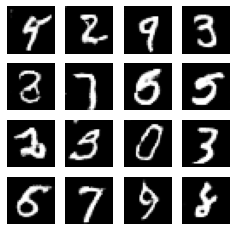

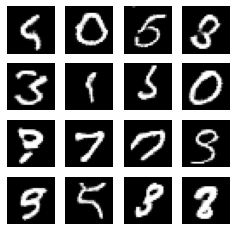

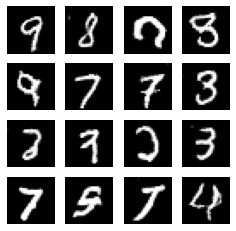

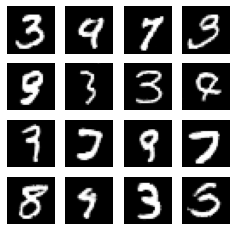

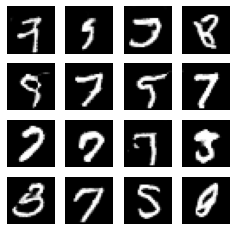

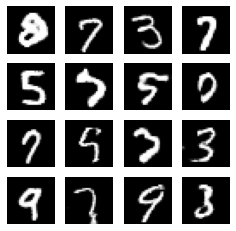

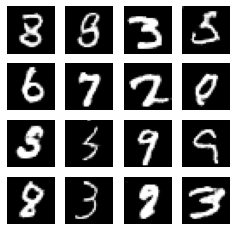

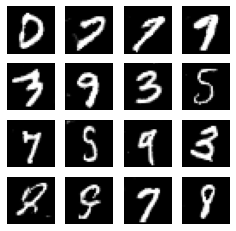

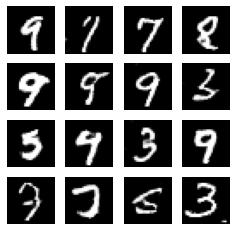

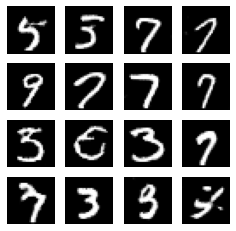

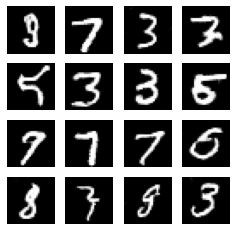

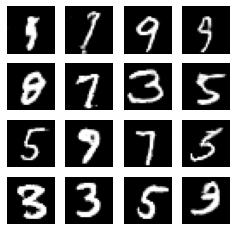

In [11]:
iterations = 20000
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval)

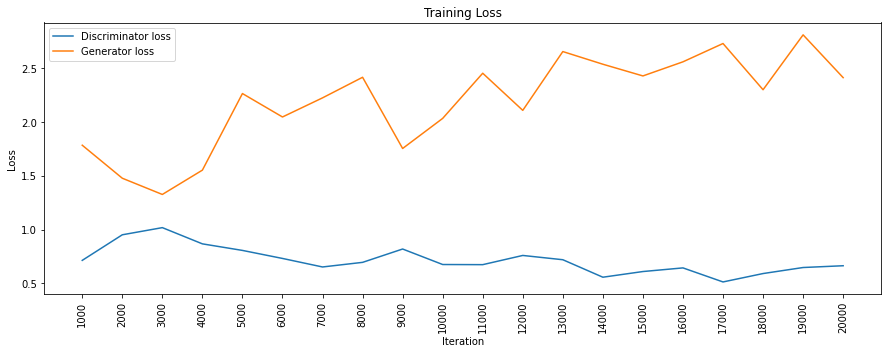

In [12]:
losses = np.array(losses)

plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()